In [68]:
import numpy as np
import skfuzzy as fuzz
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skfuzzy import control as ctrl
import warnings
warnings.filterwarnings("ignore")

In [69]:
df = pd.read_excel('dataset.xlsx', nrows=279)
df["SESSO"].replace({'M': 0., 'F': 1.}, inplace=True)
df["TARGET"].replace({2.0: 1.}, inplace=True)
for key in df.keys():
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(",", ""), errors='coerce')

correlations = np.array(df.corrwith(df['TARGET'], method="kendall"))[:-1]
print(f"Correlations with TARGET:\n", df.corrwith(df['TARGET'], method="kendall"))
beta = 0.2
chosen_corrs = correlations > beta
X = df.drop(columns='TARGET').to_numpy(dtype=np.float64)
# X = df[['Eosinofili', 'AST', 'LDH', 'PCR', 'Monociti', 'Linfociti']].to_numpy(dtype=np.float64)
X = X[:, chosen_corrs]
y = df['TARGET'].to_numpy(dtype=np.float64)

Correlations with TARGET:
 SESSO        -0.249735
AGE           0.056435
WBC          -0.178520
Piastrine    -0.092355
Neutrofili   -0.100715
Linfociti    -0.213555
Monociti     -0.185434
Eosinofili   -0.215767
Basofili     -0.171577
PCR           0.238826
AST           0.410829
ALT           0.224363
ALP          -0.074779
GGT           0.165086
LDH           0.363080
TARGET        1.000000
dtype: float64


In [70]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=300, random_state=0)
imp.fit(df)
df = np.round(imp.transform(df), 1)

In [71]:
df_train, df_test = train_test_split(df, stratify=y, random_state=104, test_size=0.2)
df_train = np.array(df_train)
df_test = np.array(df_test)

In [72]:
def sintonmf(x, a):
    x = np.array(x)
    return (x == a).astype(int)

# Adding singleton mf to skfuzzy package
fuzz.singletonmf = sintonmf

In [73]:
class Antecedent(ctrl.Antecedent):
    def get_term(self, x):
        y_s = {}
        for term in self.terms:
            varterm = getattr(self, term)
            y_s[term] = varterm[0](np.array([x]), varterm[1])[0]

        return max(y_s, key=y_s.get)

    def add_mf(self, name, mf, params):
        setattr(self, name, [mf, params])
        self.name = name
        self[name] = mf(self.universe, params)

ctrl.Antecedent = Antecedent

class Consequent(ctrl.Consequent):
    def get_term(self, x):
        y_s = {}
        for term in self.terms:
            varterm = getattr(self, term)
            y_s[term] = varterm[0](np.array([x]), varterm[1])[0]

        return max(y_s, key=y_s.get)

    def add_mf(self, name, mf, params):
        setattr(self, name, [mf, params])
        self.name = name
        self[name] = mf(self.universe, params)

ctrl.Consequent = Consequent

<h3>
Antecedents
</h3>

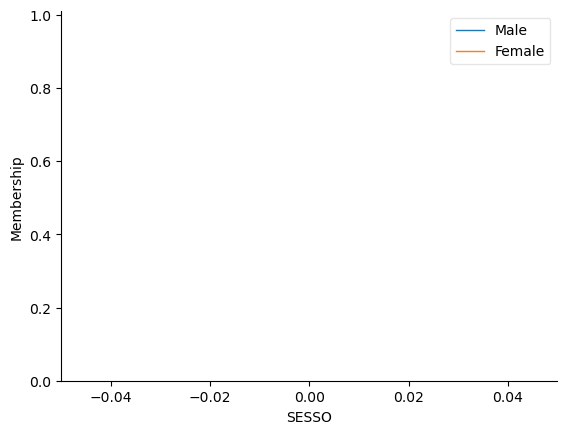

In [74]:
SESSO = ctrl.Antecedent(np.arange(0., 1., 1), 'SESSO')
SESSO.add_mf('Male', fuzz.singletonmf, 0)
SESSO.add_mf('Female', fuzz.singletonmf, 1)
SESSO.view()

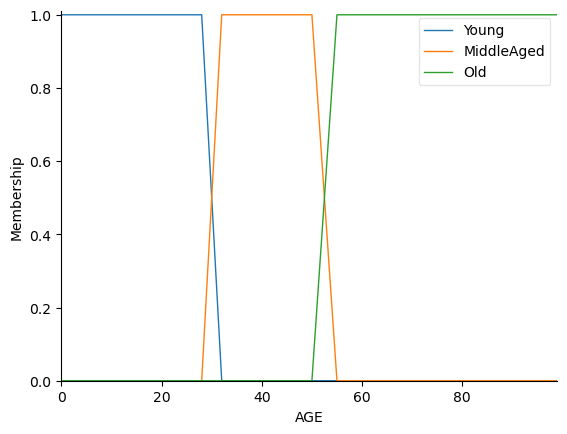

In [75]:
AGE = ctrl.Antecedent(np.arange(0, 100, 1), 'AGE')
AGE.add_mf('Young', fuzz.trapmf, [0, 0, 28, 32])
AGE.add_mf('MiddleAged', fuzz.trapmf, [28, 32, 50, 55])
AGE.add_mf('Old', fuzz.trapmf, [50, 55, 100, 100])
AGE.view()

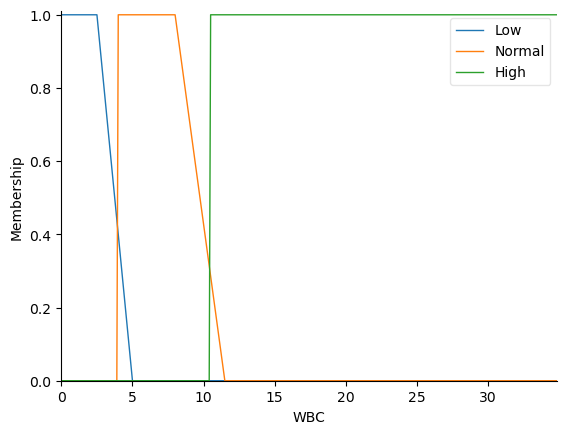

In [76]:
WBC = ctrl.Antecedent(np.arange(0, 35, 0.1), 'WBC')
WBC.add_mf('Low', fuzz.trapmf, [0, 0, 2.5, 5])
WBC.add_mf('Normal', fuzz.trapmf, [4, 4, 8, 11.5])
WBC.add_mf('High', fuzz.trapmf, [10.5, 10.5, 35, 35])
WBC.view()

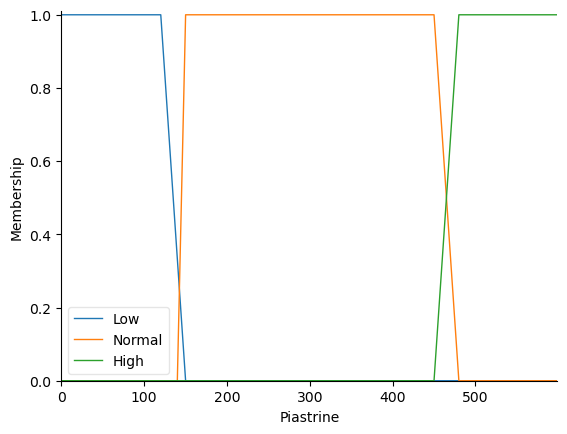

In [77]:
Piastrine = ctrl.Antecedent(np.arange(0, 600, 1), 'Piastrine')
Piastrine.add_mf('Low', fuzz.trapmf, [0, 0, 120, 150])
Piastrine.add_mf('Normal', fuzz.trapmf, [140, 150, 450, 480])
Piastrine.add_mf('High', fuzz.trapmf, [450, 480, 600, 600])
Piastrine.view()

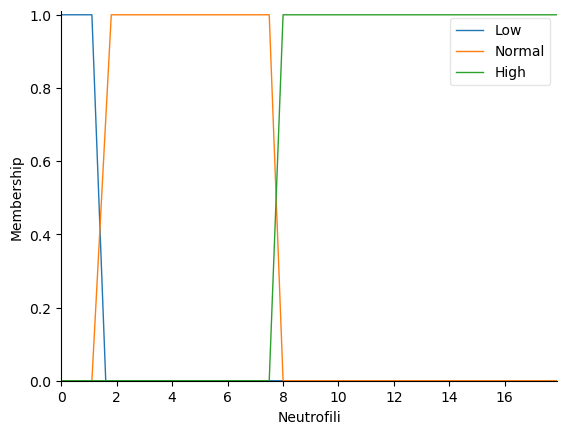

In [78]:
Neutrofili = ctrl.Antecedent(np.arange(0, 18, 0.1), 'Neutrofili')
Neutrofili.add_mf('Low', fuzz.trapmf, [0, 0, 1.1, 1.6])
Neutrofili.add_mf('Normal', fuzz.trapmf, [1.1, 1.8, 7.5, 8])
Neutrofili.add_mf('High', fuzz.trapmf, [7.5, 8, 18, 18])
Neutrofili.view()

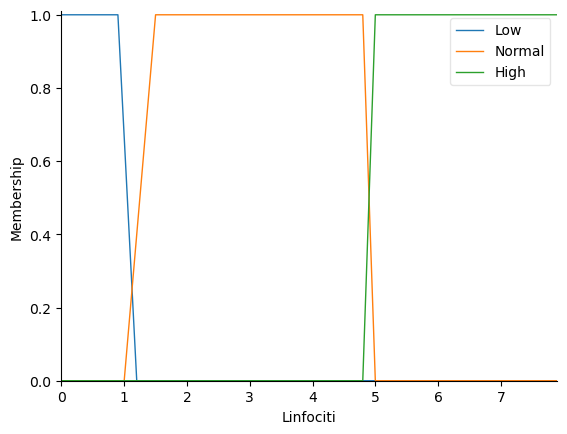

In [79]:
Linfociti = ctrl.Antecedent(np.arange(0, 8, 0.1), 'Linfociti')
Linfociti.add_mf('Low', fuzz.trapmf, [0, 0, 0.9, 1.2])
Linfociti.add_mf('Normal', fuzz.trapmf, [1, 1.5, 4.8, 5])
Linfociti.add_mf('High', fuzz.trapmf, [4.8, 5, 8, 8])
Linfociti.view()

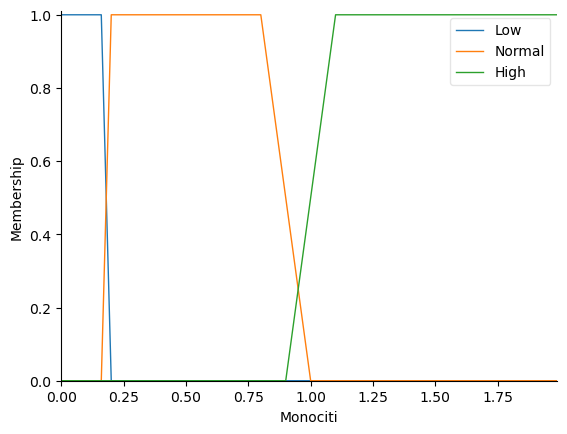

In [80]:
Monociti = ctrl.Antecedent(np.arange(0, 2, 0.01), 'Monociti')
Monociti.add_mf('Low', fuzz.trapmf, [0, 0, 0.16, 0.2])
Monociti.add_mf('Normal', fuzz.trapmf, [0.16, 0.2, 0.8, 1])
Monociti.add_mf('High', fuzz.trapmf, [0.9, 1.1, 2, 2])
Monociti.view()

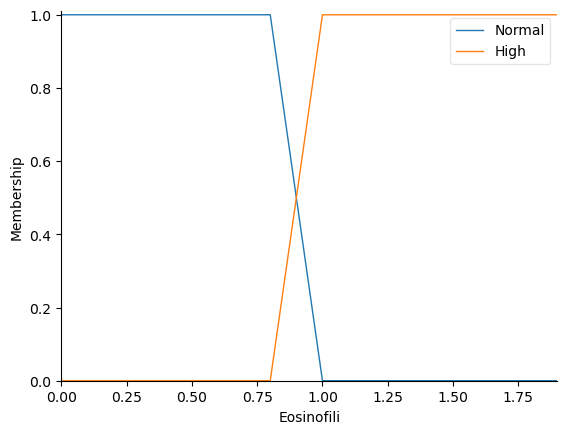

In [81]:
Eosinofili = ctrl.Antecedent(np.arange(0, 2, 0.1), 'Eosinofili')
Eosinofili.add_mf('Normal', fuzz.trapmf, [0, 0, 0.8, 1])
Eosinofili.add_mf('High', fuzz.trapmf, [0.8, 1, 2, 2])
Eosinofili.view()

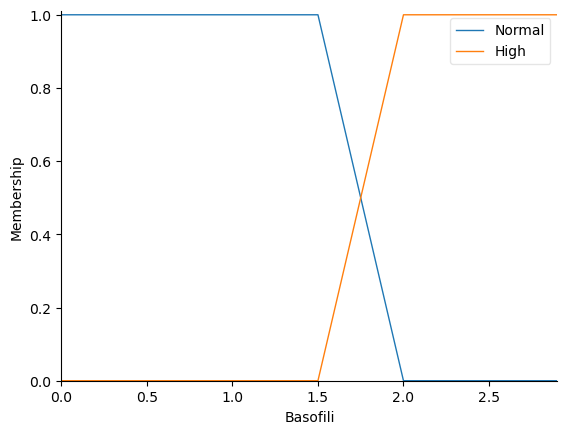

In [82]:
Basofili = ctrl.Antecedent(np.arange(0, 3, 0.1), 'Basofili')
Basofili.add_mf('Normal', fuzz.trapmf, [0, 0, 1.5, 2])
Basofili.add_mf('High', fuzz.trapmf, [1.5, 2, 3, 3])
Basofili.view()

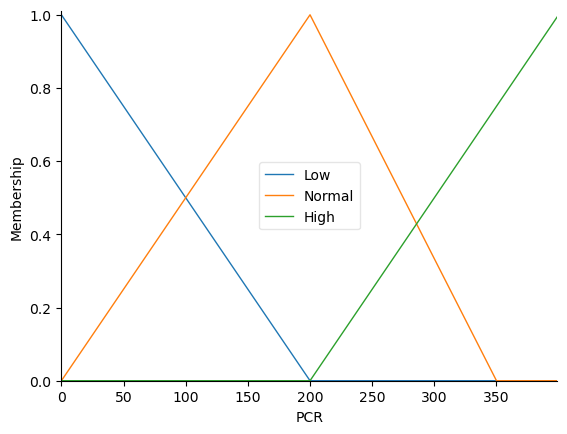

In [83]:
PCR = ctrl.Antecedent(np.arange(0, 400, 1), 'PCR')
PCR.add_mf('Low', fuzz.trimf, [0, 0, 200])
PCR.add_mf('Normal', fuzz.trimf, [0, 200, 350])
PCR.add_mf('High', fuzz.trimf, [200, 400, 400])
PCR.view()

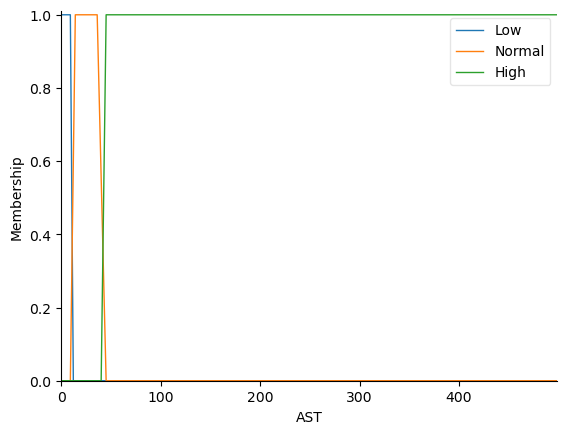

In [84]:
AST = ctrl.Antecedent(np.arange(0, 500, 1), 'AST')
AST.add_mf('Low', fuzz.trapmf, [0, 0, 9, 12])
AST.add_mf('Normal', fuzz.trapmf, [9, 14, 36, 45])
AST.add_mf('High', fuzz.trapmf, [40, 45, 500, 500])
AST.view()

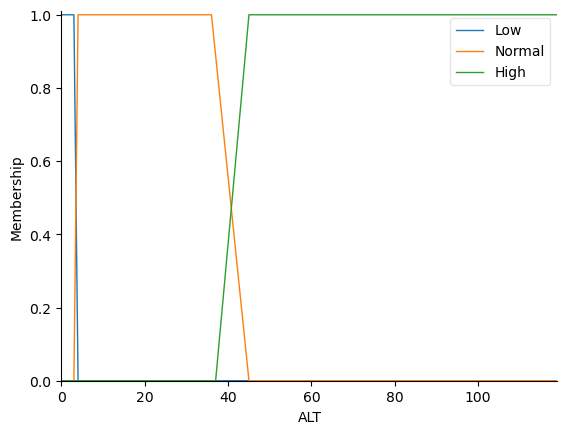

In [85]:
ALT = ctrl.Antecedent(np.arange(0, 120, 1), 'ALT')
ALT.add_mf('Low', fuzz.trapmf, [0, 0, 3, 4])
ALT.add_mf('Normal', fuzz.trapmf, [3, 4, 36, 45])
ALT.add_mf('High', fuzz.trapmf, [37, 45, 120, 120])
ALT.view()

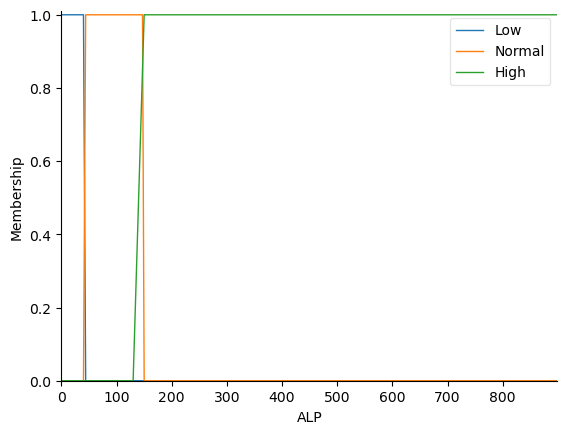

In [86]:
ALP = ctrl.Antecedent(np.arange(0, 900, 1), 'ALP')
ALP.add_mf('Low', fuzz.trapmf, [0, 0, 40, 44])
ALP.add_mf('Normal', fuzz.trapmf, [40, 44, 147, 150])
ALP.add_mf('High', fuzz.trapmf, [130, 150, 900, 900])
ALP.view()

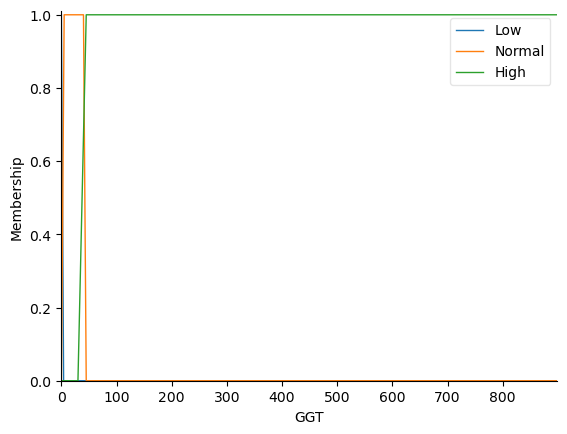

In [87]:
GGT = ctrl.Antecedent(np.arange(0, 900, 1), 'GGT')
GGT.add_mf('Low', fuzz.trimf, [0, 0, 4])
GGT.add_mf('Normal', fuzz.trapmf, [0, 5, 40, 45])
GGT.add_mf('High', fuzz.trapmf, [30, 45, 900, 900])
GGT.view()

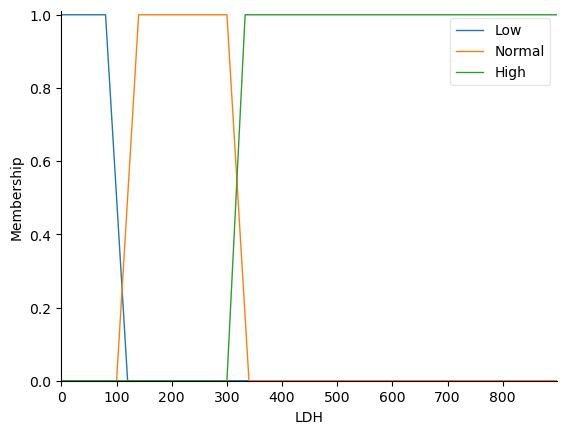

In [88]:
LDH = ctrl.Antecedent(np.arange(0, 900, 1), 'LDH')
LDH.add_mf('Low', fuzz.trapmf, [0, 0, 80, 120])
LDH.add_mf('Normal', fuzz.trapmf, [100, 140, 300, 340])
LDH.add_mf('High', fuzz.trapmf, [300, 333, 900, 900])
LDH.view()

<h3>
Consequents
</h3>

In [100]:
TARGET = ctrl.Consequent(np.arange(0, 1, 0.0001), 'TARGET')
TARGET.add_mf('Negative', fuzz.singletonmf, 0)
TARGET.add_mf('Positive', fuzz.singletonmf, 1)
# TARGET.add_mf('Negative', fuzz.trimf, 0)
# TARGET.add_mf('Positive', fuzz.trimf, 1)
# TARGET.view()

In [101]:
antecedents = [SESSO, AGE, WBC, Piastrine, Neutrofili, Linfociti, Monociti, Eosinofili, Basofili, PCR, AST, ALT, ALP, GGT, LDH]
consequents = [TARGET]

In [102]:
from functools import reduce

j = 0
rules = []

for row in df_train:
    ants = []
    for i, antecedent in enumerate(antecedents):
        ants.append(antecedent[antecedent.get_term(row[i])])
    cons = []
    for i, consequent in enumerate(consequents):
        cons.append(consequent[consequent.get_term(row[-i])])
    antecedent = reduce(lambda x, y: x & y, ants)
    consequent = reduce(lambda x, y: x & y, cons) if (len(cons) > 1) else cons
    rules.append(ctrl.Rule(antecedent, consequent))

# rules = list(set(rules))

In [103]:
covid_ctrl = ctrl.ControlSystem(rules)

In [104]:
covid_sys = ctrl.ControlSystemSimulation(covid_ctrl)

In [107]:
import math

# def test_me(test):
#     covid_sys.input['SESSO'] = test[0]
#     covid_sys.input['AGE'] = test[1]
#     covid_sys.input['WBC'] = test[2]
#     covid_sys.input['Piastrine'] = test[3]
#     covid_sys.input['Neutrofili'] = test[4]
#     covid_sys.input['Linfociti'] = test[5]
#     covid_sys.input['Monociti'] = test[6]
#     covid_sys.input['Eosinofili'] = test[7]
#     covid_sys.input['Basofili'] = test[8]
#     covid_sys.input['PCR'] = test[9]
#     covid_sys.input['AST'] = test[10]
#     covid_sys.input['ALT'] = test[11]
#     covid_sys.input['ALP'] = test[12]
#     covid_sys.input['GGT'] = test[13]
#     covid_sys.input['LDH'] = test[14]

#     # Crunch the numbers
#     covid_sys.compute()
#     print(test[15])
#     print(covid_sys.output['TARGET'])

# test_me(df_test[6])

def predict(x):
    covid_sys.input['SESSO'] = x[0]
    covid_sys.input['AGE'] = x[1]
    covid_sys.input['WBC'] = x[2]
    covid_sys.input['Piastrine'] = x[3]
    covid_sys.input['Neutrofili'] = x[4]
    covid_sys.input['Linfociti'] = x[5]
    covid_sys.input['Monociti'] = x[6]
    covid_sys.input['Eosinofili'] = x[7]
    covid_sys.input['Basofili'] = x[8]
    covid_sys.input['PCR'] = x[9]
    covid_sys.input['AST'] = x[10]
    covid_sys.input['ALT'] = x[11]
    covid_sys.input['ALP'] = x[12]
    covid_sys.input['GGT'] = x[13]
    covid_sys.input['LDH'] = x[14]
    # inp = {}
    # for i, term in enumerate(x[:(len(x)-1)]):
    #     if(not math.isnan(term)):
    #         covid_sys.input[antecedents[i].__class__.__name__] = term
    
    trueval = test[len(x)-1]
    pred = np.nan
    try:
        covid_sys.compute()
        pred = covid_sys.output['TARGET']
        pred = np.round(pred)
        pred_term = TARGET.get_term(pred)
        pred = 1 if (pred_term == "Positive") else 0
        print(f"actual: {trueval}, pred: {pred}")
    except:
        print(f"actual: {trueval}, pred: nan (Could not match record with a rule)")
    return (pred == x[len(x)-1])

count = 0

for i, test in enumerate(df_test):
    print(f"Test no.{i}")
    if(predict(test)): count += 1

Test no.0
actual: 0.0, pred: 0
Test no.1
actual: 1.0, pred: 0
Test no.2
actual: 1.0, pred: 0
Test no.3
actual: 1.0, pred: 0
Test no.4
actual: 0.0, pred: 0
Test no.5
actual: 1.0, pred: 0
Test no.6
actual: 0.0, pred: nan (Could not match record with a rule)
Test no.7
actual: 0.0, pred: 0
Test no.8
actual: 1.0, pred: nan (Could not match record with a rule)
Test no.9
actual: 1.0, pred: nan (Could not match record with a rule)
Test no.10
actual: 1.0, pred: 0
Test no.11
actual: 1.0, pred: 0
Test no.12
actual: 1.0, pred: nan (Could not match record with a rule)
Test no.13
actual: 0.0, pred: nan (Could not match record with a rule)
Test no.14
actual: 0.0, pred: nan (Could not match record with a rule)
Test no.15
actual: 1.0, pred: nan (Could not match record with a rule)
Test no.16
actual: 1.0, pred: nan (Could not match record with a rule)
Test no.17
actual: 1.0, pred: nan (Could not match record with a rule)
Test no.18
actual: 1.0, pred: 0
Test no.19
actual: 1.0, pred: nan (Could not match 

In [109]:
def get_accuract(pred_count, acutual_count):
    return (pred_count*100)/acutual_count

print("Accuracy: ", np.round(get_accuract(count, len(df_test))), "%")

Accuracy:  21.0 %
